# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64

In [3]:
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb
%run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=get_trade_in_usdt(trade_history)

In [14]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_74768\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [16]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4630.31,1.00,-131.89,2445.38,2313.49
OMUSDT,526.32,3238.37,0.70,0.00,2712.05,2712.05
BTCUSDT,601.02,730.39,0.16,3.54,129.37,132.91
SOLUSDT,281.20,224.58,0.05,0.00,-56.63,-56.63
JASMYUSDT,387.46,173.86,0.04,0.00,-213.60,-213.60
ETHUSDT,250.75,133.30,0.03,0.00,-117.44,-117.44
TRXUSDT,76.87,114.31,0.02,-10.72,37.44,26.72
BBUSDT,60.18,14.44,0.00,-39.73,-45.74,-85.47
BNBUSDT,1.14,1.07,0.00,-10.61,-0.07,-10.68
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [20]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

474

In [21]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [22]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [23]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [24]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [25]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [26]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [28]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: a8a9bd62cb914d329f702fa79cd0888d3005538c)
✅ File pushed/updated successfully!


In [29]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [31]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [32]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: ca76b13bfd4a36616f8d97c79928d4e729a2eb0e)
✅ File pushed/updated successfully!


In [33]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [34]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [35]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [36]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [37]:
# pnl_history['Total']

In [38]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [39]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [40]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [41]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [42]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-03-13    1981.620537
2025-03-14    2010.574081
2025-03-15    2202.769914
2025-03-16    2210.019473
2025-03-17    2485.773076
Name: Total, Length: 176, dtype: float64

In [43]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-03-13   -137.783248
2025-03-14     28.953544
2025-03-15    192.195833
2025-03-16      7.249559
2025-03-17    275.753603
Name: Total, Length: 176, dtype: float64

In [44]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,5)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-219.6118751223521, -334.9272908594338)

In [45]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [46]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [47]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [48]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [49]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [50]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [51]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

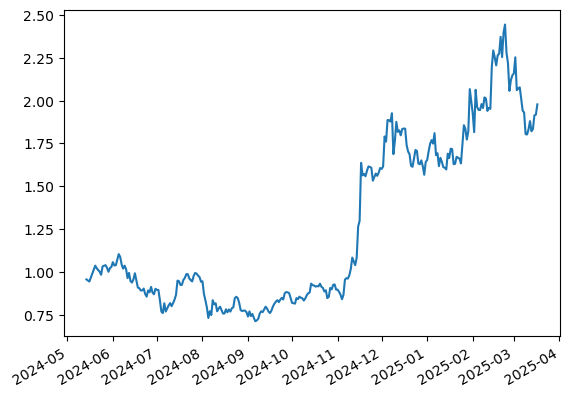

In [52]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

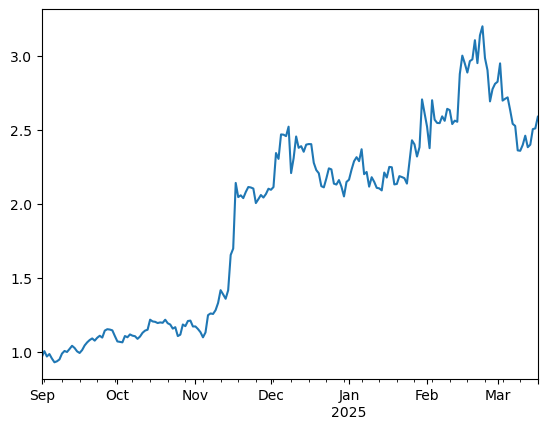

In [53]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [55]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [58]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [59]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [62]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.7794
OMUSDT,0.1373
AAVEUSDT,0.0350
BNBUSDT,0.0335
DEXEUSDT,0.0086
ADAUSDT,0.0062
PEPEUSDT,0.0000
TRXUSDT,0.0000
SUIUSDT,0.0000
BTCUSDT,0.0000


In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.468263
BTCUSDT,0.300000
OMUSDT,0.231737


In [64]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

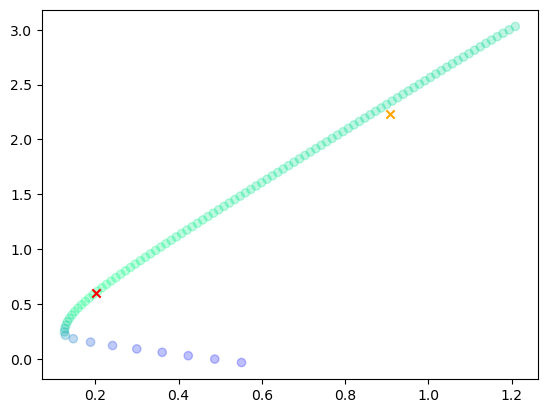

In [65]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [66]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [67]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3238.371694,0.699385,0.0637,0.635685
BTCUSDT,730.392918,0.157742,0.0000,0.157742
SOLUSDT,224.575278,0.048501,0.0000,0.048501
JASMYUSDT,173.855536,0.037547,0.0000,0.037547
ETHUSDT,133.302600,0.028789,0.0000,0.028789
TRXUSDT,114.308956,0.024687,0.0051,0.019587
BBUSDT,14.435112,0.003118,0.0000,0.003118
BNBUSDT,1.070956,0.000231,0.0659,-0.065669
PEPEUSDT,0.000002,0.000000,0.0037,-0.003700
PAXGUSDT,0.000000,0.000000,0.3989,-0.398900


### Current results

In [69]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [70]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.877611
OMUSDT,0.103910
TRXUSDT,0.018479


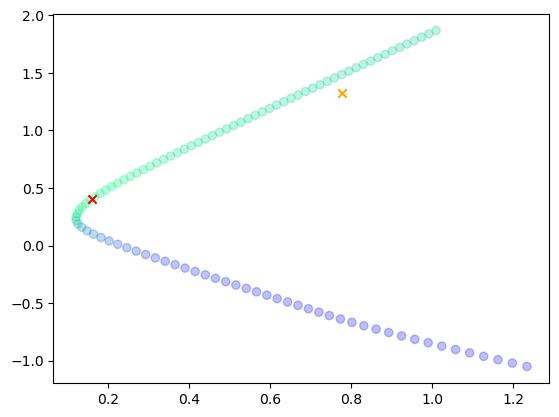

In [71]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [72]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3238.371694,0.699385,0.103910,0.595475
BTCUSDT,730.392918,0.157742,0.000000,0.157742
SOLUSDT,224.575278,0.048501,0.000000,0.048501
JASMYUSDT,173.855536,0.037547,0.000000,0.037547
ETHUSDT,133.302600,0.028789,0.000000,0.028789
TRXUSDT,114.308956,0.024687,0.018479,0.006208
BBUSDT,14.435112,0.003118,0.000000,0.003118
BNBUSDT,1.070956,0.000231,0.000000,0.000231
PEPEUSDT,0.000002,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.877611,-0.877611


# Risk Reward Analysis

In [74]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [75]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

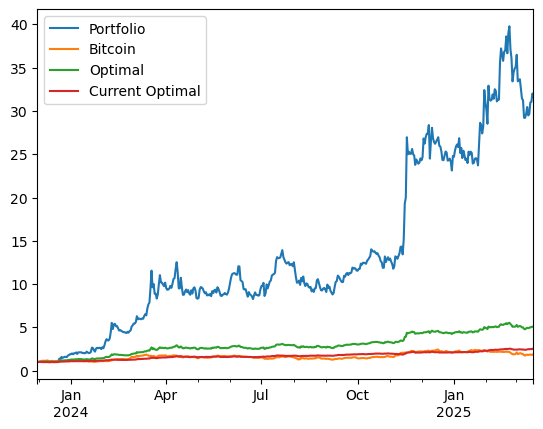

In [76]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [77]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

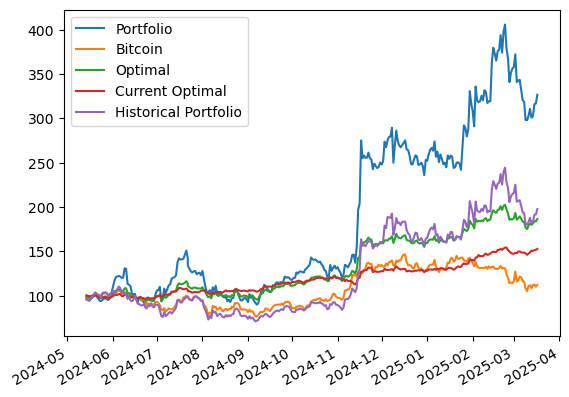

In [78]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [79]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-03-08,318.864979,115.682157,183.096230,148.746766,193.005673
2025-03-09,298.219995,108.074181,176.984617,147.599680,180.399004
2025-03-10,297.990552,105.172891,175.220783,146.153736,180.191407
2025-03-11,302.826009,110.822138,179.011010,147.430736,183.215484
2025-03-12,310.753904,111.816046,181.494502,148.889551,187.971314
2025-03-13,300.860853,108.335893,180.050580,150.916192,182.047066
2025-03-14,302.639009,112.099402,181.342583,150.425263,183.335317
2025-03-15,316.098799,112.572571,184.133293,151.567509,191.350939
2025-03-16,316.824428,110.193184,183.803146,151.718786,191.748673
2025-03-17,326.683860,112.092354,186.540798,152.830092,197.754476


## Volatilities

In [81]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.354663
 dtype: float64,
 0.35502767404157115)

In [82]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.777705
 dtype: float64,
 0.7777045470857414)

In [83]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.907376
Bitcoin            0.433749
Optimal            0.355028
Current Optimal    0.176484
dtype: float64

In [84]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4690606667707048

In [85]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-1.752710191502707

In [86]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.7057569569009523

## Risk Contribution

In [88]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.250363,0.300000,0.027243,0.233004,0.134337,0.098667
OMUSDT,18.720942,0.231737,0.938166,0.721758,0.622457,0.099302
PAXGUSDT,0.230536,0.468263,0.034591,0.045238,0.028947,0.016291


In [89]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.472515,0.103910,0.329199,0.481283,0.430578,0.050704
TRXUSDT,0.006726,0.018479,0.014395,0.023518,0.008220,0.015297
PAXGUSDT,0.271753,0.877611,0.656406,0.495200,0.454804,0.040395


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.183147,0.70,0.933435,0.894692,0.826377,0.068314
BTCUSDT,0.028789,0.16,0.045381,0.041849,0.007365,0.034484
SOLUSDT,-0.019478,0.05,0.007337,0.023973,0.002231,0.021742
JASMYUSDT,-0.025609,0.04,0.003459,0.024896,0.003202,0.021695
ETHUSDT,-0.014067,0.03,0.003830,0.009215,0.000497,0.008718
TRXUSDT,0.007280,0.02,0.006558,0.005375,0.000407,0.004968


# Value At Risk

## Historical

### Optimal Weights

In [94]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.028388219491727092, -0.04002574763159416)

### Current Weights

In [96]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05629769177910666, -0.08214405943169349)

In [97]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [98]:
var=historical_var.iloc[row]
var

OMUSDT      -0.044789
BTCUSDT     -0.006831
SOLUSDT     -0.001492
JASMYUSDT   -0.002165
ETHUSDT     -0.002305
TRXUSDT      0.000143
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.057438
Name: 2024-08-04 00:00:00, dtype: float64

In [99]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.066833
BTCUSDT     -0.005744
SOLUSDT     -0.003678
JASMYUSDT   -0.003561
ETHUSDT     -0.001699
TRXUSDT     -0.000628
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.082144
dtype: float64

## Parametric

### Optimal Weights

In [102]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.03678656133661378, -0.04715020071262809)

### Current Weights

In [104]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.08058266471864713, -0.103284696296443)

## Multivariate

### Optimal Weights

In [107]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03280534076712708, -0.04269872052796982)

### Current Weights

In [109]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07637425115579222, -0.09647076577348264)

In [110]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

OMUSDT      -0.068157
BTCUSDT     -0.002914
SOLUSDT     -0.001573
JASMYUSDT   -0.001697
ETHUSDT     -0.000656
TRXUSDT     -0.000423
Portfolio   -0.075420
dtype: float64

In [111]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

OMUSDT      -0.069695
BTCUSDT     -0.002988
SOLUSDT     -0.001290
JASMYUSDT   -0.001385
ETHUSDT     -0.000767
TRXUSDT     -0.000337
Portfolio   -0.076462
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [115]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03402615200226996, -0.04430555610923449)

### Current Weights

In [117]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07818159028288893, -0.09756905802486768)

In [118]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [121]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0332288920005977, -0.042319004508284845)

### Current Weights

In [123]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07729863721628445, -0.09960297347302777)

In [124]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [127]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06533773866867028, -0.09431644187780974)

### Current Weights

In [129]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.16002307807318053, -0.22024731195644492)

In [130]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [133]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [134]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.037492385291865514, -0.046082259384798555)

### Current Weights

In [136]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08290631865260686, -0.1032088742026364)

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [138]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.157735,-0.067360,-0.072881,-0.068157,-0.066949
BTCUSDT,-0.000005,-0.002975,-0.003747,-0.002914,-0.003603
SOLUSDT,-0.000144,-0.001911,-0.002106,-0.001573,-0.002232
JASMYUSDT,-0.000311,-0.001765,-0.002216,-0.001697,-0.002411
ETHUSDT,-0.000093,-0.000829,-0.000833,-0.000656,-0.000863
TRXUSDT,-0.000241,-0.000394,-0.000437,-0.000423,-0.000373
Portfolio,-0.158530,-0.075234,-0.082220,-0.075420,-0.076432


In [139]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.157531,-0.068562,-0.073478,-0.069695,-0.066541
BTCUSDT,-0.001829,-0.003229,-0.003669,-0.002988,-0.004011
SOLUSDT,0.000050,-0.001887,-0.002342,-0.001290,-0.002565
JASMYUSDT,-0.001526,-0.001504,-0.002220,-0.001385,-0.002718
ETHUSDT,0.000026,-0.000821,-0.000867,-0.000767,-0.000962
TRXUSDT,0.000180,-0.000107,-0.000622,-0.000337,-0.000459
Portfolio,-0.160630,-0.076111,-0.083198,-0.076462,-0.077256


## VaR Violation

In [141]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.028930,-0.054187,-0.046250,-0.011857
2024-01-15,-0.028930,-0.054192,-0.046813,0.012407
2024-01-16,-0.028930,-0.054251,-0.045169,0.024962
2024-01-17,-0.028930,-0.055629,-0.047537,-0.019865
2024-01-18,-0.028930,-0.056527,-0.047810,-0.015602
...,...,...,...,...
2025-03-14,-0.038859,-0.046389,-0.047151,0.007176
2025-03-15,-0.038859,-0.046877,-0.046290,0.015389
2025-03-16,-0.038859,-0.043389,-0.044454,-0.001793
2025-03-17,-0.038859,-0.043339,-0.043697,0.014894


In [142]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.045379,-0.084160,-0.083013,-0.015006
2024-05-29,-0.045379,-0.082059,-0.079294,-0.007208
2024-05-30,-0.045379,-0.072331,-0.071855,0.025761
2024-05-31,-0.045379,-0.076553,-0.074589,0.049656
2024-06-01,-0.045379,-0.083514,-0.079369,0.067499
...,...,...,...,...
2025-03-14,-0.081193,-0.078726,-0.090652,0.005910
2025-03-15,-0.081193,-0.084282,-0.092114,0.044475
2025-03-16,-0.081193,-0.084114,-0.091953,0.002296
2025-03-17,-0.081193,-0.082356,-0.087593,0.031120


<Axes: >

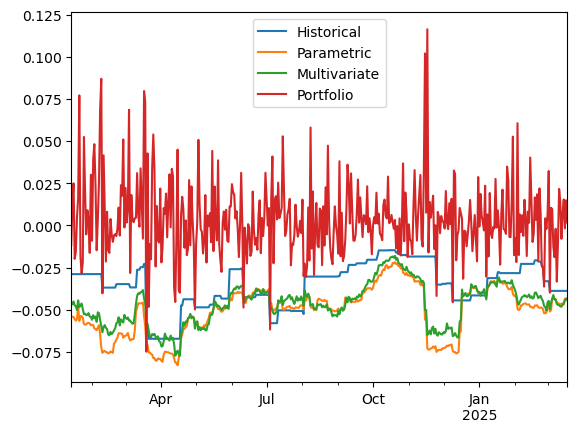

In [143]:
var_data.plot()

<Axes: >

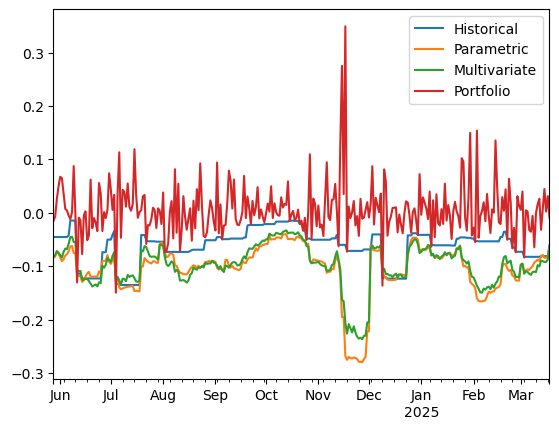

In [144]:
current_var_data.plot()

In [145]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032558,0.006977,0.006977
Kupiec Stat,3.124987,26.008809,26.008809
P-value,0.0771,0.0,0.0


In [146]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064407,0.010169,0.010169
Kupiec Stat,1.186224,14.430112,14.430112
P-value,0.276093,0.000145,0.000145


# Principal Component Analysis

## Historical PCA

In [149]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.81174872, 0.05663939, 0.04978129, 0.04668265, 0.03514794])

In [150]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.017608
ADAUSDT      0.019003
ALGOUSDT     0.020036
APTUSDT      0.017735
ARBUSDT      0.019359
ATOMUSDT     0.017532
AVAXUSDT     0.019536
BCHUSDT      0.015600
BNBUSDT      0.009162
BONKUSDT     0.023998
BTCUSDT      0.009886
CAKEUSDT     0.018402
DEXEUSDT     0.013673
DOGEUSDT     0.018811
DOTUSDT      0.018066
EOSUSDT      0.018323
ETCUSDT      0.016406
ETHUSDT      0.013496
FDUSDUSDT    0.000051
FETUSDT      0.023001
FILUSDT      0.019859
FLOWUSDT     0.019280
GALAUSDT     0.023451
GRTUSDT      0.021639
HBARUSDT     0.018952
ICPUSDT      0.017866
IMXUSDT      0.019981
INJUSDT      0.020989
IOTAUSDT     0.021269
JASMYUSDT    0.021294
LDOUSDT      0.020668
LINKUSDT     0.017820
LTCUSDT      0.013339
MKRUSDT      0.013109
NEARUSDT     0.021582
NEXOUSDT     0.011562
OMUSDT       0.010944
OPUSDT       0.019887
PAXGUSDT     0.000265
PEPEUSDT     0.024512
QNTUSDT      0.015578
SANDUSDT     0.021536
SEIUSDT      0.021276
SHIBUSDT     0.018381
SOLUSDT      0.016467
STXUSDT   

<Axes: >

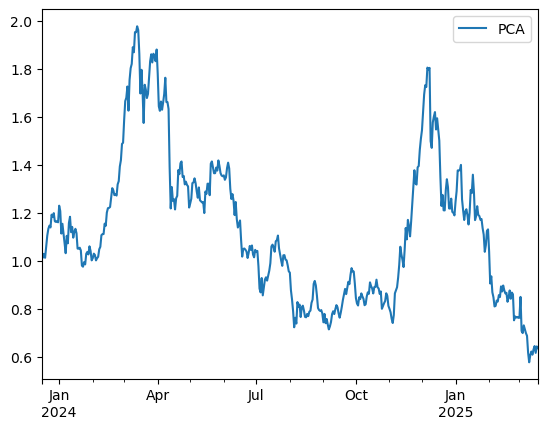

In [151]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

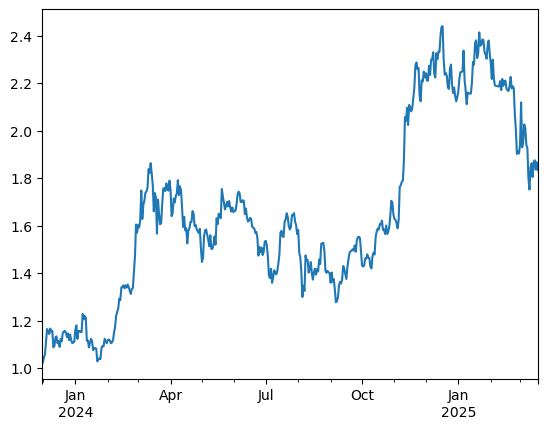

In [152]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [153]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.426376
WBETHUSDT    0.461377
ETHUSDT      0.461774
ATOMUSDT     0.475219
DOTUSDT      0.477724
ETCUSDT      0.490089
NEXOUSDT     0.513873
EOSUSDT      0.542759
AVAXUSDT     0.548014
BTCUSDT      0.550806
WBTCUSDT     0.550836
FILUSDT      0.565664
IOTAUSDT     0.567218
ARBUSDT      0.580664
GRTUSDT      0.582276
XTZUSDT      0.583070
LINKUSDT     0.609508
VETUSDT      0.612147
IMXUSDT      0.623273
dtype: float64

<Axes: >

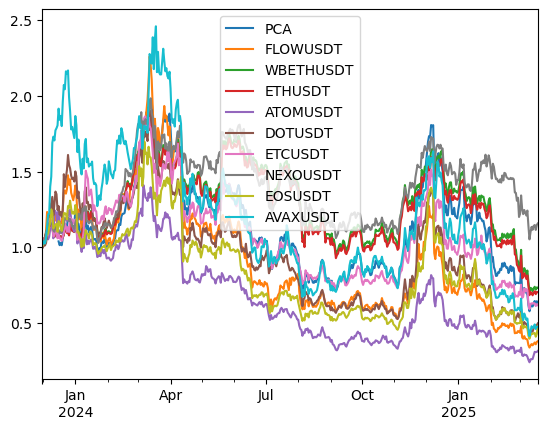

In [154]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

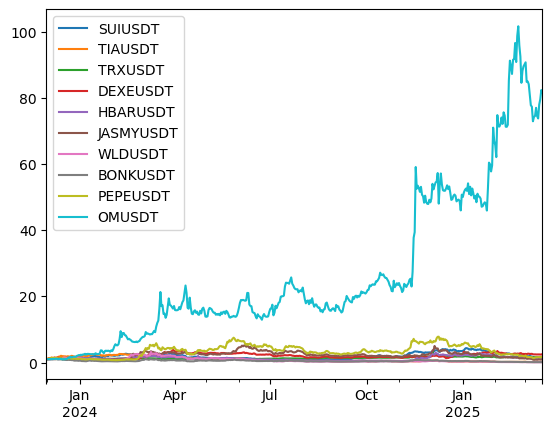

In [155]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [157]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59679946, 0.14080247, 0.10909031, 0.08842274, 0.06488502])

In [158]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.088343
BTCUSDT      0.061188
SOLUSDT      0.108071
JASMYUSDT    0.172621
ETHUSDT      0.089046
TRXUSDT      0.051137
BBUSDT       0.197875
BNBUSDT      0.065784
PEPEUSDT     0.163053
PAXGUSDT     0.002882
Name: PC1, dtype: float64

<Axes: >

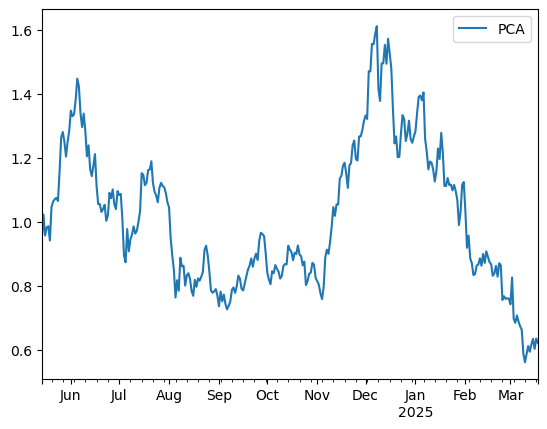

In [159]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

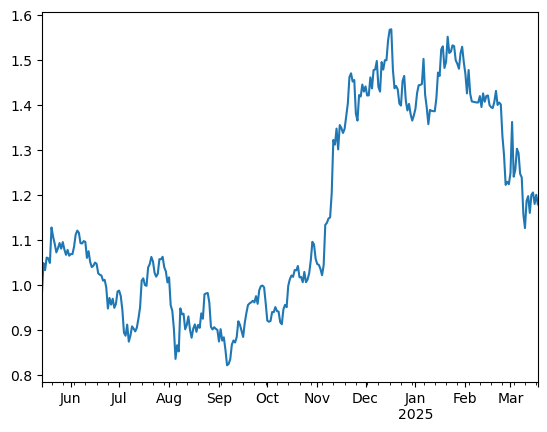

In [160]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [161]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.449942
BNBUSDT      0.506364
BTCUSDT      0.515232
SOLUSDT      0.526937
JASMYUSDT    0.706963
PEPEUSDT     0.760787
PAXGUSDT     0.781715
BBUSDT       0.807184
TRXUSDT      0.948608
dtype: float64

<Axes: >

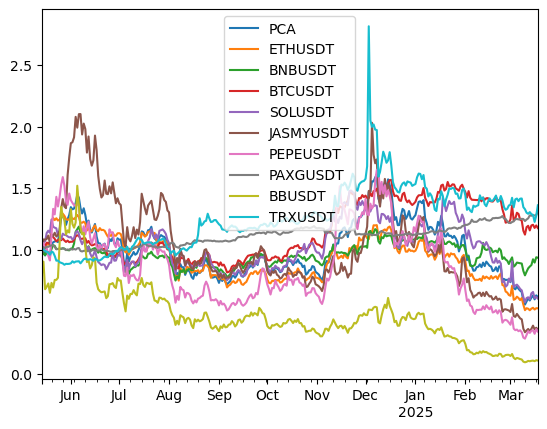

In [162]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [164]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.881488
BBUSDT       1.579590
JASMYUSDT    1.379294
SOLUSDT      1.240452
ETHUSDT      1.012101
BTCUSDT      1.000000
OMUSDT       0.875390
BNBUSDT      0.669463
TRXUSDT      0.339345
PAXGUSDT     0.037333
Name: BTCUSDT, dtype: float64

In [165]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT      1.843194
PEPEUSDT     1.644516
JASMYUSDT    1.586846
BBUSDT       1.373784
ETHUSDT      1.305217
BTCUSDT      1.000000
BNBUSDT      0.680320
OMUSDT       0.633503
TRXUSDT      0.413697
PAXGUSDT     0.026957
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [167]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [168]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BNBUSDT,0.231035
ETHUSDT,0.206667
BBUSDT,0.169620
BTCUSDT,0.166918
JASMYUSDT,0.136125
SOLUSDT,0.097727
TRXUSDT,0.094966
PEPEUSDT,0.072920
OMUSDT,-0.072798
PAXGUSDT,-0.218009


### Regression to PCA

In [170]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.0454756916785442

In [171]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.297913
BNBUSDT      1.163080
ETHUSDT      1.000112
PCA          1.000000
PAXGUSDT     0.747661
SOLUSDT      0.708990
JASMYUSDT    0.471047
PEPEUSDT     0.438314
BBUSDT       0.408707
TRXUSDT      0.285643
OMUSDT       0.249770
dtype: float64

In [172]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.412367
BTCUSDT      1.336287
PCA          1.000000
TRXUSDT      0.998487
ETHUSDT      0.956218
JASMYUSDT    0.776747
BBUSDT       0.676524
SOLUSDT      0.644056
PEPEUSDT     0.643355
OMUSDT       0.636097
PAXGUSDT    -0.034370
dtype: float64

### Correlation Matrix

<Axes: >

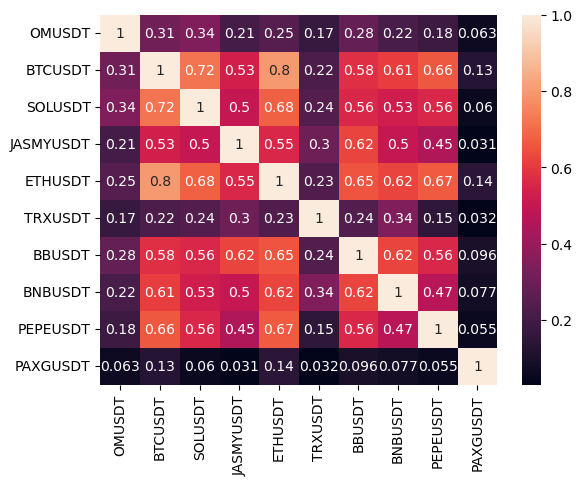

In [174]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

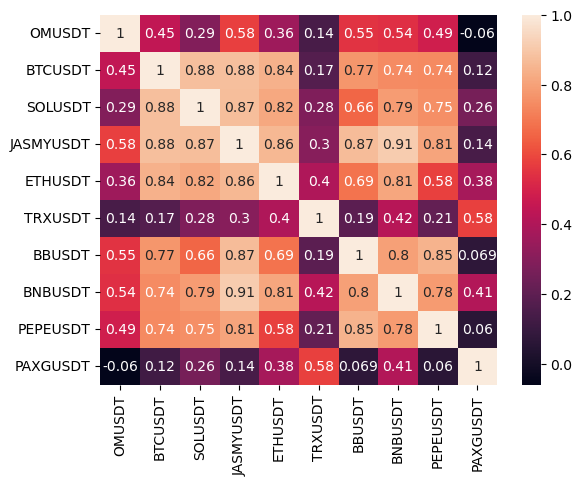

In [175]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [177]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.626168,0.000000,0.000000,0.150876,0.000000,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.019283,0.260704,0.086231,0.000000,0.000000,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.435186,0.000000,0.000000,0.000000,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.176734,0.000000,0.000000,0.000000,0.166022,0.526886,0.000000,0.000000,0.130357,0.000000


In [178]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-08-10,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.802984,0.0
2024-09-09,0.05306,0.007964,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.135553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-10-09,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.320535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-11-08,0.00000,0.008643,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-12-08,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223762,0.0
2025-01-07,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-02-06,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-08,0.00000,0.092123,0.0,0.0,0.0,0.0,0.0,0.261892,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-18,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [179]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

PAXGUSDT    0.871375
OMUSDT      0.101057
CAKEUSDT    0.025556
ADAUSDT     0.002012
SOLUSDT     0.000000
LTCUSDT     0.000000
Name: 2025-03-18 00:00:00, dtype: float64

In [180]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
